# Facial Recognition ML Model Description & Credit

***Description*** This is the second iteration of a machine-learning model for facial recognition. The first was using HC, Haar-Cascading, which utilized a sub frame-by-frame analysis to see if the smaller frame matches a database of current comparisions and highlights them. While this model worked well for distinct features (face, eyes), it struggled with harder to decipher features (mouth). I hope to fix this with using Histogram of Oriented Gradients.

***Histogram of Oriented Gradients***
From my readings, HOG is fed an grey-scale image, then utilizes selection of specific portions of the image and breaks down the image in a 1:2 ratio portion. It then takes each individual part of the 2:1, and further breaks it down into a 8x8 pixel grid. In each of these pixels, the difference between the pixel above and below the box is calculated (Gx) and left and right (Gy). These values are then used to find the overall gradient difference using magnitude calculation (distance formula) and angle calculation (arctan). The Gx and Gy values are also normalized (division by the magnitude) in order to hold differences the same if the original image is changes. After this calculation is done for all pixels in the 8x8, they are seperated into 9 "bins" based on angle. The bids span 20 degrees (0˚-20˚, 21-40˚, etc.), and the magnitutde of that corresponding pixel is then distributed between the bins. These are then used to create vectors to each of the degrees. This gradient vector graph is present for each 8x8 pixel-grid, and shows the difference between 2 grey-scale values, with higher-brightness gradients showing key differences and the complexitiy of the gradient showing the difference in contrast.



***Credit****


*   https://builtin.com/articles/histogram-of-oriented-gradients

# Importing Libraries

In [2]:
pip install opencv-python

In [3]:
pip install numpy

In [47]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog
import numpy as np

#Photo Capture


In [154]:
#Links collab and camera
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
def take_Photo(filename = 'photo.jpg', quality = 0.8):
  js = Javascript('''
  async function takePhoto(quality) {
  const div = document.createElement('div');
  const capture = document.createElement('button');
  capture.textContent = 'Capture';
  div.appendChild(capture);
  const video = document.createElement('video');
  video.style.display = 'block';
  const stream = await navigator.mediaDevices.getUserMedia({video:true});
  document.body.appendChild(div);
  div.appendChild(video);
  video.srcObject = stream;
  await video.play();
  //Resize the output to fit the video element.
  google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
  // Wait for Image Capture
  await new Promise((resolve) => capture.onclick = resolve);
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth
  canvas.height = video.videoHeight
  canvas.getContext('2d').drawImage(video,0,0);
  stream.getVideoTracks()[0].stop();
  div.remove();
  return canvas.toDataURL('image/jpeg',quality);
    }
  ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename,'wb') as f:
    f.write(binary)
    return filename



<IPython.core.display.Javascript object>

Saved to photo.jpg


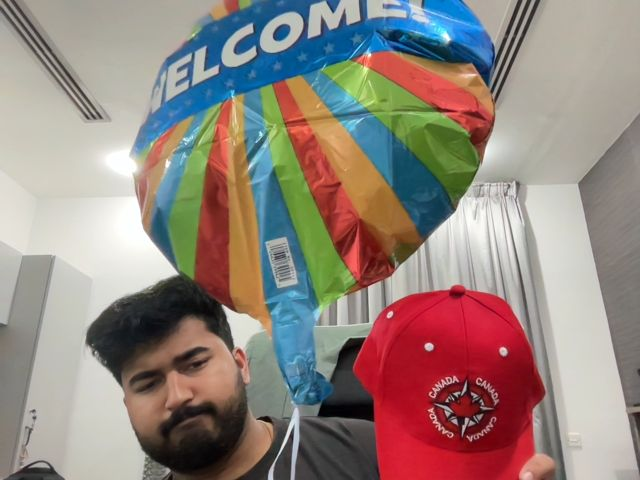

In [155]:
from IPython.display import Image
try:
  filename = take_Photo()
  print('Saved to {}'.format(filename))
  #Show the image which was just taken.
  display(Image(filename))
except Exception as err:
    print(str(err))

# Processing

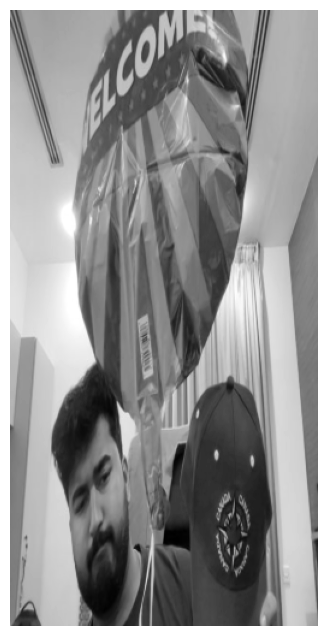

In [156]:
##Change quality:
ySize = 512
xSize = int(ySize/2)



img = resize(color.rgb2gray(io.imread("photo.jpg")), (ySize, xSize))
resized_img = resize(img,(ySize, xSize))
plt.figure(figsize=(15, 8))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [157]:
img = np.array(img)

In [169]:

mag = []
theta = []
for row in range(ySize):
  magnitudeArray = []
  angleArray = []
  for col in range(xSize):
    # Condition for axis 0
    if col-1 <= 0 or col+1 >= xSize:
      if col-1 <= 0:
        # Condition if first element
        Gx = img[row][col+1] - 0
      elif col + 1 >= len(img[0]):
        Gx = 0 - img[row][col-1]
    # Condition for first element
    else:
      Gx = img[row][col+1] - img[row][col-1]

    # Condition for axis 1
    if row-1 <= 0 or row+1 >= ySize:
      if row-1 <= 0:
        Gy = 0 - img[row+1][col]
      elif row +1 >= ySize:
        Gy = img[row-1][col] - 0
    else:
      Gy = img[row-1][col] - img[row+1][col]

    # Calculating magnitude
    magnitude = math.sqrt(pow(Gx, 2) + pow(Gy, 2))
    magnitudeArray.append(round(magnitude, 9))

    # Calculating angle
    if Gx == 0:
      angle = math.degrees(0.0)
    else:
      angle = math.degrees(abs(math.atan(Gy / Gx)))
    angleArray.append(round(angle, 9))
  mag.append(magnitudeArray)
  theta.append(angleArray)

In [159]:
mag = np.array(mag)

In [160]:
theta = np.array(theta)

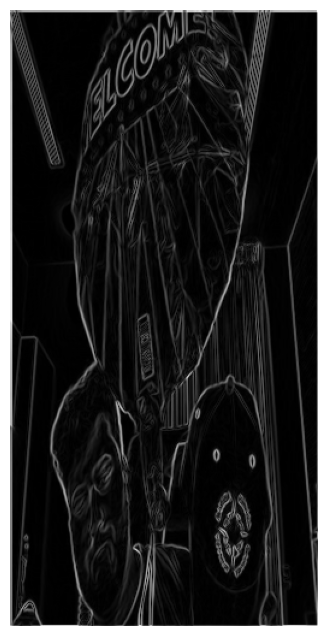

In [161]:
plt.figure(figsize=(15, 8))
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

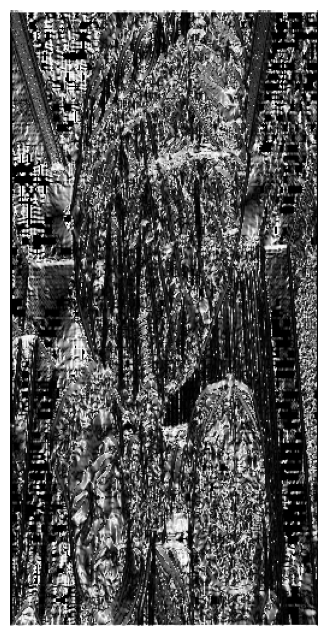

In [162]:
plt.figure(figsize=(15, 8))
plt.imshow(theta, cmap="gray")
plt.axis("off")
plt.show()

In [163]:
number_of_bins = 9
step_size = 180 / number_of_bins

In [164]:
def calculate_j(angle):
  temp = (angle / step_size) - 0.5
  j = math.floor(temp)
  return j

In [165]:
def calculate_Cj(j):
  Cj = step_size * (j + 0.5)
  return round(Cj, 9)

In [166]:
def calculate_value_j(magnitude, angle, j):
  Cj = calculate_Cj(j+1)
  Vj = magnitude * ((Cj - angle) / step_size)
  return round(Vj, 9)


In [167]:
histogram_points_nine = []
for i in range(0, ySize, 8):
  temp = []
  for j in range(0, xSize, 8):
    magnitude_values = [[mag[i][x] for x in range(j, j+8)] for i in range(i,i+8)]
    angle_values = [[theta[i][x] for x in range(j, j+8)] for i in range(i, i+8)]
    for k in range(len(magnitude_values)):
      for l in range(len(magnitude_values[0])):
        bins = [0.0 for _ in range(number_of_bins)]
        value_j = calculate_j(angle_values[k][l])
        Vj = calculate_value_j(magnitude_values[k][l], angle_values[k][l], value_j)
        Vj_1 = magnitude_values[k][l] - Vj
        bins[value_j]+=Vj
        bins[value_j+1]+=Vj_1
        bins = [round(x, 9) for x in bins]
    temp.append(bins)
  histogram_points_nine.append(temp)

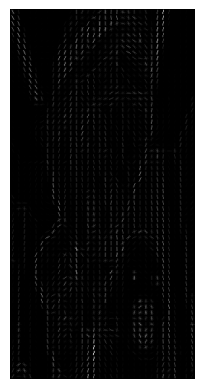

In [168]:

fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
plt.show()